# Gaussian processes

References:

https://domino.ai/blog/fitting-gaussian-process-models-python

https://stackoverflow.com/questions/47517230/gaussian-process-posterior-python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(2023)

In [2]:
# This is a basic RBF kernel function
theta = [1, 0.8]


def kernel(x, y, params=theta):
    return params[0] * np.exp(-0.5 * np.subtract.outer(x, y) ** 2 / (params[1] ** 2))

Conditioning:

$p(x|y) = N(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y - \mu_y), \Sigma_x - \Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$

In [3]:
noise = 0.2  # noise level of observations

In [4]:
def conditional(x_new, x, y):
    # p(x|y) = p(x_new|x)
    sigma_new_old = kernel(x_new, x)  # Sigma_{new, old}

    sigma_old = kernel(x, x)  # Sigma_{old, old}
    sigma_old = sigma_old + noise**2 * np.eye(sigma_old.shape[0])  # y = f(x) + noise
    lambda_old = np.linalg.inv(sigma_old)

    sigma_new = kernel(x_new, x_new)  # Sigma_{new, new}

    mu_conditional = sigma_new_old.dot(lambda_old).dot(y)
    sigma_conditional = sigma_new - sigma_new_old.dot(lambda_old).dot(sigma_new_old.T)

    return (mu_conditional.squeeze(), sigma_conditional.squeeze())

In [5]:
def plot(x_pred, predictions, x, y):
    mu_pred = predictions[0]
    sigma_pred = np.sqrt(np.diag(predictions[1]))
    plt.plot(x_pred, mu_pred, "blue", label="Posterior mean", linestyle="dashed")
    plt.fill_between(
        x_pred,
        mu_pred - 2 * sigma_pred,
        mu_pred + 2 * sigma_pred,
        color="blue",
        alpha=0.2,
        label="95% confidence interval",
    )
    plt.plot(x, y, "red", marker="o", linestyle="None", label="Observations")
    for i in range(3):
        plt.plot(
            x_pred,
            rng.multivariate_normal(predictions[0], predictions[1], method="svd"),
            label=f"Sample {i}",
        )
    plt.legend()
    plt.show()

## Default prior

In [6]:
x_pred = np.arange(-3, 3, 0.05)

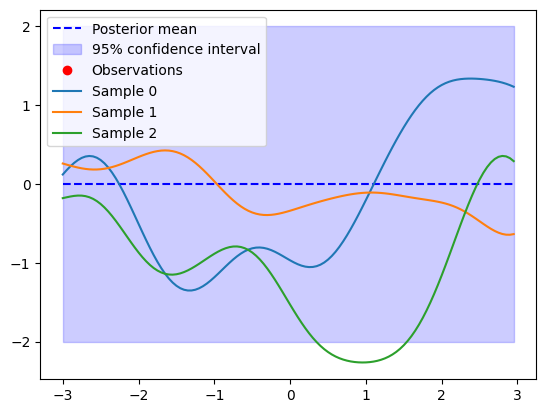

In [7]:
plot(x_pred, (0 * x_pred, kernel(x_pred, x_pred)), [], [])

## Adding a first observation

In [8]:
x = [1.0]
y = [rng.normal(scale=theta[0])]
print(y)

[0.9573061622012647]


In [9]:
predictions = conditional(x_pred, x, y)

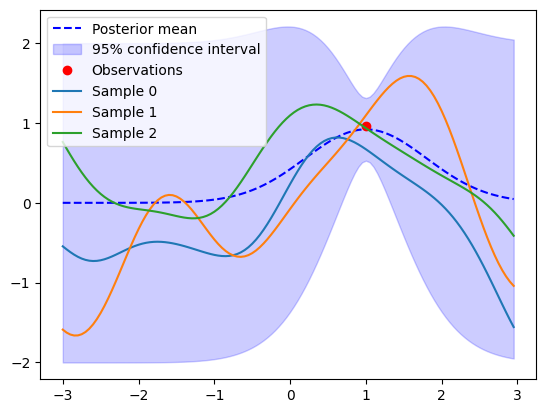

In [10]:
plot(x_pred, predictions, x, y)

## Adding a second observation

In [11]:
x2 = -0.7
m, s = conditional([x2], x, y)
y2 = rng.normal(m, s)
print(y2)

0.3569755136114008


In [12]:
x.append(x2)
y.append(y2)
predictions = conditional(x_pred, x, y)

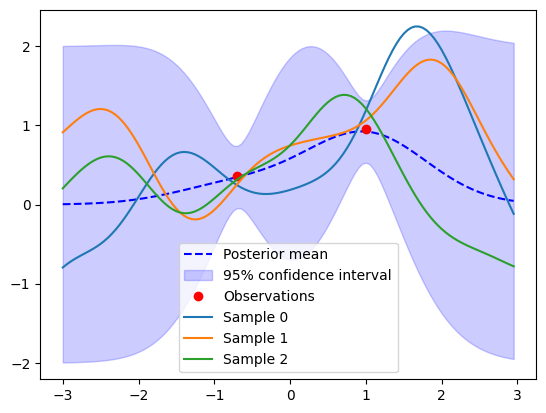

In [13]:
plot(x_pred, predictions, x, y)

## Adding a couple more observations all at once

In [14]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y)
y_more = rng.multivariate_normal(mu, s)
print(y_more)
x += x_more
y += y_more.tolist()

[ 0.0521592  -0.70221006  0.80512327  1.5001592   0.68758948]


In [15]:
predictions = conditional(x_pred, x, y)

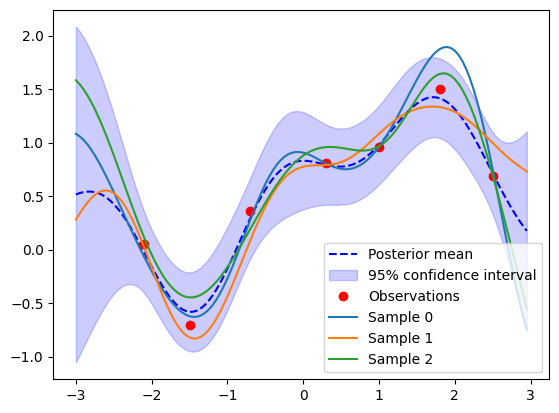

In [16]:
plot(x_pred, predictions, x, y)